# Console Simulator

In [ ]:
sys.path

In [ ]:
import sys
# sys.path.append('/content/cityscapesScripts')
sys.path.

In [ ]:
! git clone https://github.com/mcordts/cityscapesScripts

In [ ]:
import os
os.

In [ ]:
!cd cityscapesScripts
!cd sample_data
!ls
# !python setup.py

# Prerequisite Installation

In [1]:
! pip install remotezip

In [3]:
!conda install -y gdown

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
 - pytorch
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.14.0            |     pyhd8ed1ab_0          16 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    openssl-3.3.1              |       h4ab18f5_0         2.8 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.8 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.14.0-pyhd8ed1ab_0 
  gdown              conda-forge/noarch::gdown-5.2.0-pyhd8ed1ab_0 

The following packages will be UPDATED:

  openssl     

In [2]:
! python -m pip install cityscapesscripts cityscapesscripts[gui]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.4 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.6/473.6 kB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 41.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 25.3 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 23.6 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=f04b5317507d8ff0150c313b86020ca23c3984a2fac0cd489045667206f665d7
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


# Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import cv2
# from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


2024-06-06 10:55:26.088417: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 10:55:26.088567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 10:55:26.208846: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset

## Initializing Session Object

In [5]:
import cityscapesscripts

In [6]:
from cityscapesscripts.download import downloader

In [7]:
session = downloader.login()

Cityscapes username or email address:  ishansrivastava_it22a9_35@dtu.ac.in
Cityscapes password:  ··············
Store credentials unencrypted in '/root/.local/share/cityscapesscripts/credentials.json' [y/N]:  n


## RemoteZip Approach

In [ ]:
import requests
import zipfile
import io
from remotezip import RemoteZip
import threading, multiprocessing
import concurrent.futures
import time

class DataExplorer:
    def __init__(
            self,
            name : str = "",
            url : str = "",
            session : requests.sessions.Session | None = None,
    ):
        self.name = name
        self.url = url
        self.session = session
        self.files_list = []
        self.cache_list = []

    def _check_files_list(self):
        if not self.files_list:
            self.files_list = self.get_file_contents()

    def get_filtered_list(self,filter,start = None,end = None,**kwargs):
        self._check_files_list()
        return [f for f in self.files_list if filter(f)][start:end]

    def download_with_filter(
            self,
            filter,
            destination_path : str = "",
            **kwargs

    ):
        self._check_files_list()
        self.cache_list = self.get_filtered_list(filter,**kwargs)
        self.download_listed_files(self.cache_list,destination_path=destination_path)

    def download_with_filter_parallel(
            self,
            filter,
            destination_path : str = "",
            **kwargs

    ):
        self._check_files_list()
        self.cache_list = self.get_filtered_list(filter,**kwargs)
        return self.download_in_parallel(self.cache_list,destination_path=destination_path,**kwargs)


    def get_file_contents(self):
        """
        returns list of file contents
        url : url of the zip file
        """
        with RemoteZip(self.url, session = self.session) as z:
            zip_contents = z.namelist()
            return sorted(zip_contents);

    def download_listed_files(
        self,file_list : list[str] | str,
        destination_path : str = "",
    ):
        """
        file_list : list of files to be extracted
        """

        with RemoteZip(self.url,session = self.session) as z:
            for file in file_list:
                try:
                    z.extract(file,destination_path)
                    print(f"Task {file} downloaded succesfully")
                except Exception as e:
                    print(f"Task {file} generated an exception: {e}")

    def download_in_parallel(
            self,file_list : list[str] | str,
            destination_path : str = "",
            rate = 200,
            **kwargs
    ):
        """
        file_list : list of files to be extracted
        url : url of the zip file
        """
        count = 0
        semaphore = multiprocessing.Semaphore(rate)
        lock = multiprocessing.Lock()
        logs = multiprocessing.Array('i', [0,0,0])
        def _extract(z,file_name,destination_path,logs, *args):
            retries = 3
            while retries:
                with semaphore:
                    try:
                        z.extract(file_name,destination_path,*args)
                        with logs.get_lock():
                            logs[0] += 1
                            # print(f"Task {file_name} downloaded succesfully")
                        return
                    except Exception as e:
                        with logs.get_lock():
                            # print(f"Task {file_name} generated an exception: {e}")
                            # print(f"Retrying... {retries} retry remaining")
                            logs[2] += 1
                        time.sleep(0.01)
                    retries -= 1
            with logs.get_lock():
                logs[2] += 1

        with RemoteZip(self.url,session = self.session) as z:
            processes = []

            for file in file_list:
                process = multiprocessing.Process(target=_extract, args=(z,file,destination_path,logs))
                processes.append(process)
                process.start()
                # time.sleep(0.01)


            for thread in processes:
                thread.join()

            stats = {
                "Success" : logs[0],
                "Fails" : logs[1],
                "retries" : logs[2]
            }
            return stats


### Initialization of downloader objects

In [ ]:
class dobj:
    gtfine_data = DataExplorer(
        url = "https://www.cityscapes-dataset.com/file-handling/?packageID=1",
        session=session,
        name="gtfine"
    )
    leftimg = DataExplorer(
        url = "https://www.cityscapes-dataset.com/file-handling/?packageID=3",
        session=session,
        name="leftimg"
    )
    rightimg = DataExplorer(
        url = "https://www.cityscapes-dataset.com/file-handling/?packageID=5",
        session=session,
        name="rightimg"
    )

In [ ]:
dobj.gtfine_data.get_file_contents()

### Downloading

In [8]:
sample = dobj.gtfine_data.get_filtered_list(
    filter = lambda x : x.startswith('gtFine/train') and x.endswith('gtFine_labelIds.png')
    # destination_path = "",
    # rate = 9999,
)[:10]

NameError: name 'dobj' is not defined

In [9]:
result = dobj.gtfine_data.download_in_parallel(
    file_list=sample,
    destination_path = "",
    rate = 9999,
)

NameError: name 'dobj' is not defined

In [ ]:
result

In [ ]:
import os
os.listdir('/')

In [ ]:
for s in sample:
    img = cv2.imread(s)
    # cv2_imshow(img)
    print(img.max(),img.min())

In [ ]:
dobj.leftimg.get_file_contents()

## Direct Download

In [9]:
from cityscapesscripts.download import downloader

In [10]:
# view datasets
downloader.list_available_packages(session = session)

The following packages are available for download.
Please refer to https://www.cityscapes-dataset.com/downloads/ for additional packages and instructions on properly citing third party packages.
 gtFine_trainvaltest.zip -> 241MB
 gtCoarse.zip -> 1.3GB
 leftImg8bit_trainvaltest.zip -> 11GB
 leftImg8bit_trainextra.zip -> 44GB
 rightImg8bit_trainvaltest.zip -> 11GB
 rightImg8bit_trainextra.zip -> 44GB
 disparity_trainvaltest.zip -> 3.5GB
 disparity_trainextra.zip -> 15GB
 camera_trainvaltest.zip -> 2MB
 camera_trainextra.zip -> 8MB
 vehicle_trainvaltest.zip -> 2MB
 vehicle_trainextra.zip -> 7MB
 leftImg8bit_demoVideo.zip -> 6.6GB
 all_demoVideo.zip -> 59GB
 leftImg8bit_blurred.zip -> 11GB
 leftImg8bit_sequence_trainvaltest.zip -> 324GB
 timestamp_sequence.zip -> 40MB
 vehicle_sequence.zip -> 56MB
 rightImg8bit_sequence_trainvaltest.zip -> 322GB
 disparity_sequence_trainvaltest.zip -> 106GB
 leftImg8bit_allFrames_frankfurt.zip -> 241GB
 timestamp_allFrames_frankfurt.zip -> 29MB
 vehicle_al

In [11]:
# Saving name of datasets in variables
images_dataset = 'leftImg8bit_trainvaltest.zip'
segmentation_dataset = 'gtFine_trainvaltest.zip'

In [ ]:
downloader.download_packages(
    session = session,
    package_names=[
        images_dataset,
        segmentation_dataset,
    ],
    destination_path = '/',
    resume = True,
)

Download progress:  22%|██▏       | 2.42G/11.0G [01:30<05:12, 29.5MB/s]    

## Extraction

In [ ]:
import zipfile
import multiprocessing

class Extracter:
    def __init__(
            self,
            path : str = ""
    ):
        self.path = path
        self.files_list = None

    def _check_files_list(self):
        if not self.files_list :
            self.files_list = self.get_files_list()

    def extract_with_filter(
            self,
            filter,
            destination_path : str = ""
    ):
        self._check_files_list()
        temp = [f for f in self.files_list if filter(f)]
        return self.extract_listed_files(
            temp,destination_path
        )

    def extract_listed_files(self, files_to_extract, destination_path = ""):
        self._check_files_list()
        lock = multiprocessing.Lock()
        arr = multiprocessing.Array('i',[0,0,0])
        def _extract(z,file_name,destination_path,arr, *args):
            retries = 3
            while retries:
                try:
                    z.extract(file_name,destination_path,*args)
                    with arr.get_lock():
                        arr[0]+=1
                        # print(f"Task {file_name} extracted succesfully")
                    return
                except Exception as e:
                    retries -= 1
                    with arr.get_lock():
                        # print(f"Task {file_name} generated an exception: {e}")
                        arr[1] += 1
            with arr.get_lock():
                arr[2] += 1
        processes = []
        with zipfile.ZipFile(self.path, 'r') as zip_ref:
            # List all files in the zip
            all_files = zip_ref.namelist()

            for file in files_to_extract:
                pr = multiprocessing.Process(target = _extract, args = [zip_ref,file,destination_path,arr])
                processes.append(pr)
                pr.start()

            for pr in processes:
                pr.join()
        return {
            "success" : arr[0],
            "retries" : arr[1],
            "fail" : arr[2]
        }

    def extract_all(self):
        with zipfile.ZipFile(self.path,'r') as z:
            z.extractall()

    def get_files_list(self):
        with zipfile.ZipFile(self.path,'r') as z:
            return sorted(z.namelist())

In [ ]:
class exObj:
    segments = Extracter('/gtFine_trainvaltest.zip')
    images = Extracter('/leftImg8bit_trainvaltest.zip')

In [ ]:
# exObj.segments.extract_with_filter(
#     filter = lambda x : x,
# )

In [ ]:
exObj.images.extract_all()
exObj.segments.extract_all()

In [ ]:
import cv2
arr = cv2.imread('/content/gtFine/test/bielefeld/bielefeld_000000_000321_gtFine_color.png')

In [ ]:
arr.max()

In [ ]:
arr.min()

In [ ]:
arr.max()

# Data Exploration

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import threading

def display_images_in_grid(image_paths, grid_size):
    """
    Display images in a grid.

    Parameters:
    image_paths (list): List of image file paths.
    grid_size (tuple): Number of rows and columns in the grid.
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 10))
    axes = axes.flatten()
    lock = threading.Lock()
    img_arr = [None] * len(image_paths)
    def get_arr(i):
        img = mpimg.imread(image_paths[i])
        # with lock:
        img_arr[i] = img

    threads = []
    for i, img_path in enumerate(image_paths):
        th = threading.Thread(target = get_arr, args = [i])
        threads.append(th)
        th.start()
    for th in threads:
        th.join()

    # print(image_paths)

    for ax,arr in zip(axes,img_arr):
        ax.imshow(arr)
        ax.axis('off')
    # Hide remaining axes if there are fewer images than grid cells
    for ax in axes[len(image_paths):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
_ = cv2.imread('gtFine/test/berlin/berlin_000000_000019_gtFine_color.png')
cv2_imshow(_)

In [ ]:
path_lists.image_file_names[10:13]

In [ ]:
_ = leftimg.get_filtered_list(
    lambda x : x.startswith('leftImg8bit/train/') and x.endswith('.png'),
    start = 5, end = 10
    )

In [ ]:
_ = leftimg.download_with_filter(
    lambda x : x.startswith('leftImg8bit/train/') and x.endswith('.png'),
    start = 5, end = 10
    )

In [ ]:
display_images_in_grid(
    leftimg.get_filtered_list(
    lambda x : x.startswith('rightImg8bit/train/') and x.endswith('.png'),
    start = 5, end = 10
    ),
    [3,2]
)

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(arr)

# Data Preprocessing

## Input Pipeline

In [21]:
output_files = [f for f in (exObj.images.get_files_list()) if f.endswith('.png')]

In [22]:
train_x = [f for f in output_files if f.startswith('leftImg8bit/train')]
val_x = [f for f in output_files if f.startswith('leftImg8bit/val')]
# test_x = [f for f in output_files if f.startswith('leftImg8bit/test')]

In [23]:
train_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/train') and f.endswith('gtFine_labelIds.png')]
val_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/val') and f.endswith('gtFine_labelIds.png')]
# test_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/test') and f.endswith('gtFine_labelIds.png')]

In [24]:
train_y_color = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/train') and f.endswith('gtFine_color.png')]
val_y_color = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/val') and f.endswith('gtFine_color.png')]
# test_y_color = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/test') and f.endswith('gtFine_color.png')]

In [25]:
train_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/train') and f.endswith('gtFine_labelIds.png')]
val_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/val') and f.endswith('gtFine_labelIds.png')]
# test_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/test') and f.endswith('gtFine_labelIds.png')]

In [11]:
len(train_y_label)

2975

In [12]:
len(val_y_label)

500

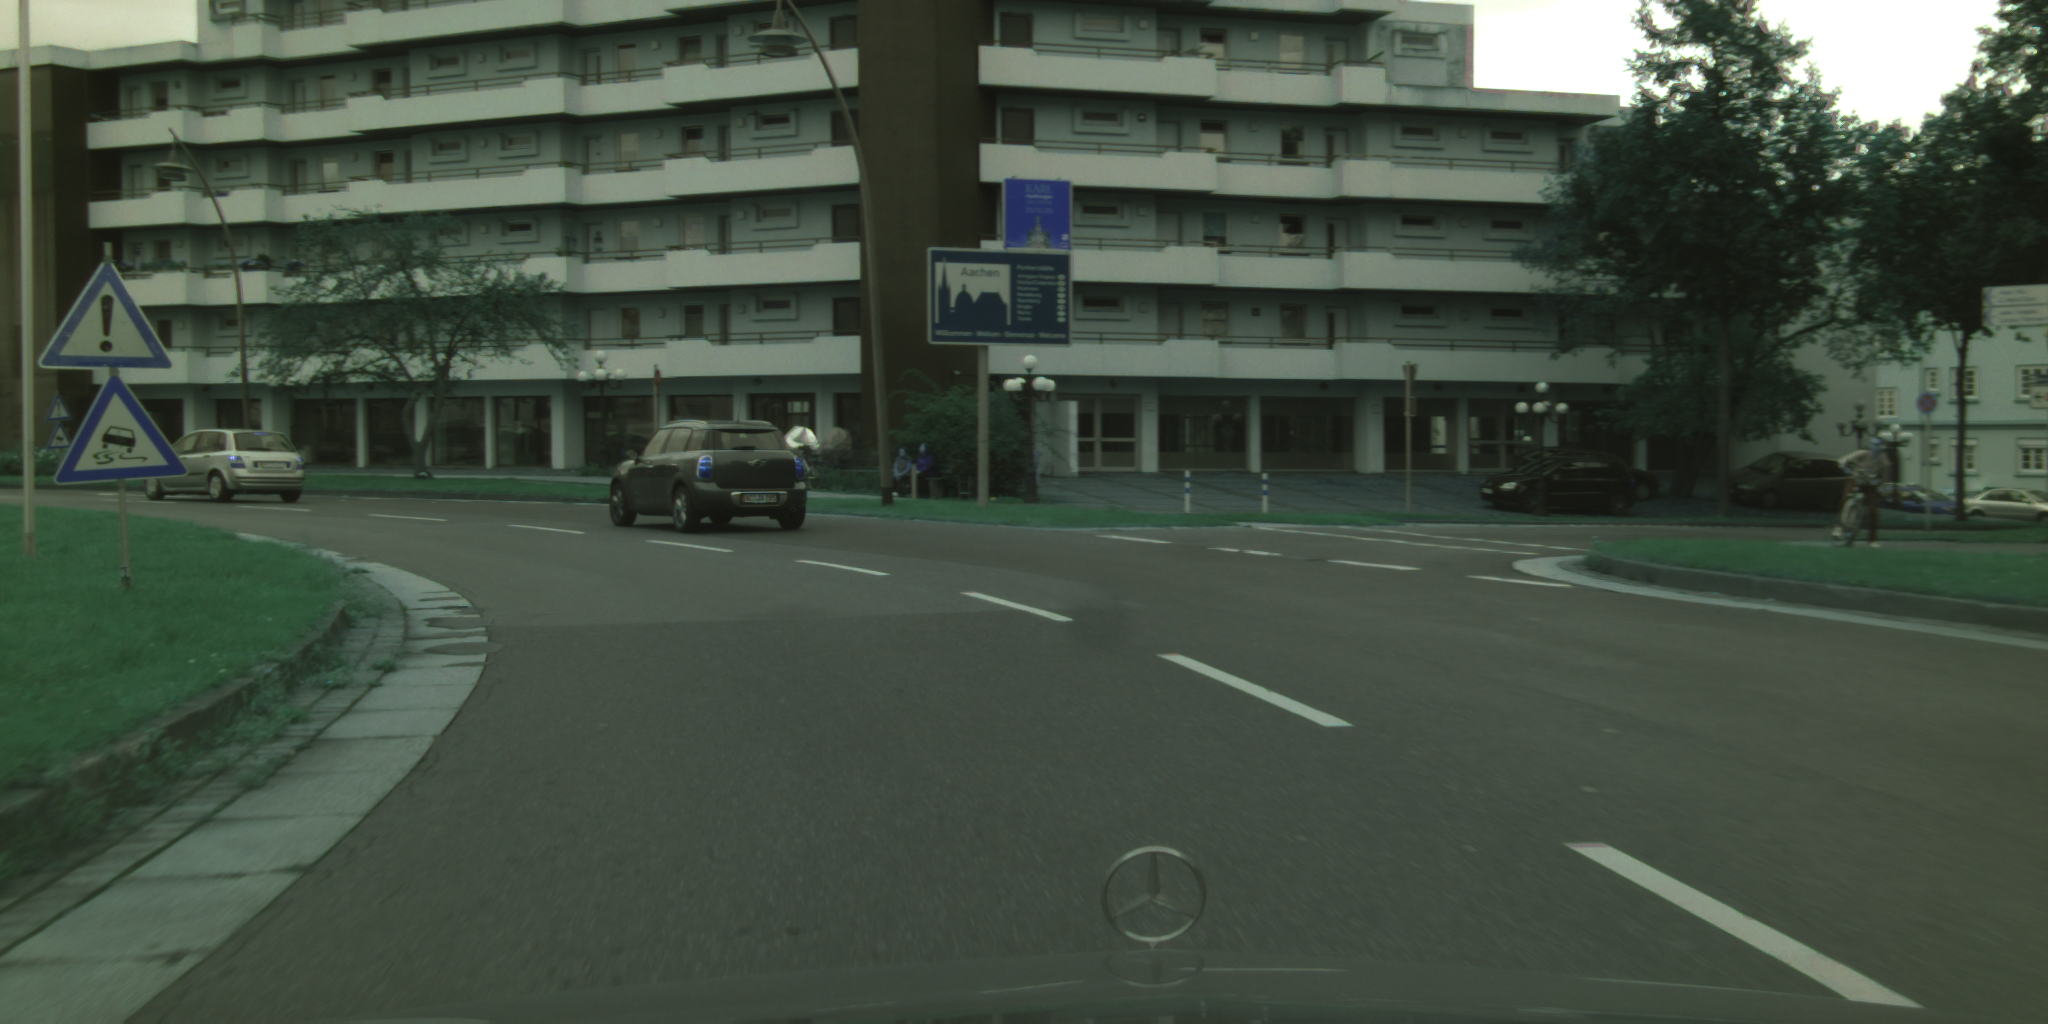

In [23]:
image = cv2.imread(train_x[0])
tf.keras.utils.array_to_img(image)

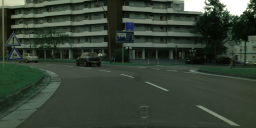

In [33]:
image = tf.image.resize(image,(128,256),method=tf.image.ResizeMethod.AREA)
tf.keras.utils.array_to_img((image/255))

In [ ]:
import tensorflow as tf

class Preprocessor:
    def __init__(
            self,
            filepaths : list[str]
    ):
        self.filepaths = filepaths
        self.dataset = None





    def get_dataset_iterator(self,func):
        if self.dataset:
            return self.dataset

        self.dataset = tf.data.Dataset.from_tensor_slices(self.filepaths)

        self.dataset = self.dataset.map(func, num_parallel_calls=tf.data.AUTOTUNE)

        # self.dataset = self.dataset.cache()
        # self.dataset = self.dataset.shuffle(buffer_size=1000)
        # self.dataset = self.dataset.batch(32)
        # self.dataset = self.dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return self.dataset
@tf.function
def load_preprocess_y(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [128, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image
    
@tf.function
def load_preprocess_x(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 256])
    image = image / 255.0
    return image

In [ ]:
train_ds_x = Preprocessor(train_x).get_dataset_iterator(load_preprocess_x)
val_ds_x = Preprocessor(val_x).get_dataset_iterator(load_preprocess_x)
# test_ds_x = Preprocessor(test_x).get_dataset_iterator()


In [ ]:
train_y,val_y = train_y_label,val_y_label
# train_y,val_y = train_y_color,val_y_color



In [ ]:
train_ds_y = Preprocessor(train_y).get_dataset_iterator(load_preprocess_y)
val_ds_y = Preprocessor(val_y).get_dataset_iterator(load_preprocess_y)
# test_ds_y = Preprocessor(test_x).get_dataset_iterator()

In [ ]:
dataset_train = tf.data.Dataset.zip(train_ds_x, train_ds_y)
dataset_val = tf.data.Dataset.zip(val_ds_x, val_ds_y)


In [ ]:
train_ds_x.as_numpy_iterator().next().shape

In [ ]:
def optimize_datasets(dataset):
        dataset = dataset.cache()
        # dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.batch(32)
        dataset = dataset.prefetch(buffer_size=2)
        return dataset

In [ ]:
dataset_train = optimize_datasets(dataset_train)
dataset_val = optimize_datasets(dataset_val)

In [ ]:
temp = dataset_train.as_numpy_iterator().next()

In [ ]:
import numpy as np

In [ ]:
x = (temp[0][2])
y = (temp[1][2])

In [ ]:
keras.utils.array_to_img(x)

# Data Distribution

In [ ]:
train_ds_y = optimize_datasets(train_ds_y)

In [ ]:
img = train_ds_y.as_numpy_iterator().next()

In [ ]:
train_ds_x = optimize_datasets(train_ds_x)

In [ ]:
x_img = train_ds_x.as_numpy_iterator().next()

In [ ]:
x_img.shape

In [ ]:
cv2_imshow(x_img[1].astype(np.int8))

In [ ]:
cv2_imshow(img[1].astype(np.int8))

In [ ]:
img.shape
plt.subplots(8,8,)

In [ ]:
img[:,:,:,:1].shape

In [ ]:
from collections import defaultdict
from pprint import pprint
distribution = defaultdict(int)

In [ ]:
for image in train_ds_y.as_numpy_iterator():
    img = image[:,:,:,:1]
    img.flatten()
    labels,count = np.unique(img,return_counts=True)
    for i,label in enumerate(labels):
        distribution[label] += count[i]

pprint(distribution)


In [ ]:

# Extract labels and frequencies
labels = list(distribution.keys())
frequencies = list(distribution.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, frequencies, color='skyblue')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Labels')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# NN

## Model

In [51]:
img_x, img_y = 128,256

# Model 3

In [53]:
def inverse_stack_module(inp,filters):
    c_3_1 = layers.Conv2DTranspose(filters,3,activation = 'relu')(inp)
    c_3_2 = layers.Conv2DTranspose(filters,3,activation = 'relu')(c_3_1)
    c_5 = layers.Conv2DTranspose(filters,5,activation = 'relu')(inp)
    concat = layers.Concatenate()([c_5,c_3_2])
    return concat
def stack_module(inp,filters):
    c_3_1 = layers.Conv2D(filters,3,activation = 'relu')(inp)
    c_3_2 = layers.Conv2D(filters,3,activation = 'relu')(c_3_1)
    c_5 = layers.Conv2D(filters,5,activation = 'relu')(inp)
    concat = layers.Concatenate()([c_5,c_3_2])
    return concat

In [54]:
inp = tf.keras.Input((img_x,img_y,3))

sm1 = stack_module(inp,30) # (124,252,60)
sm2_f1 = stack_module(sm1,60) # (120,248,120)
mp1_f2 = layers.MaxPool2D()(sm2_f1) # (60,124,120)
c1x = layers.Conv2D(30,1)(mp1_f2) # (60,124,30)

sm1 = stack_module(c1x,120)  # (56,120,240)
sm2 = stack_module(sm1,120)  # (52,116,240)
mp1_f1 = layers.MaxPool2D()(sm2) # (26,58,240)
c1x = layers.Conv2D(30,1)(mp1_f1) # (26,58,30)

sm1 = stack_module(c1x,240)  # (None, 22, 54, 480) 
sm2 = stack_module(sm1,240)  # (18,50,480)
mp1 = layers.MaxPool2D()(sm2) # (18,50,480)

c1x = layers.Conv2D(30,1)(sm2) # (18,50,30)

# up1 = layers.UpSampling2D()(mp1) # (18,50,480)
sm1 = inverse_stack_module(c1x,120)  # (None, 22, 54, 240) 
sm2 = inverse_stack_module(sm1,120)  # (26,58,240)
up1 = layers.UpSampling2D()(sm2 + mp1_f1) # (52,116,240)

c1x = layers.Conv2D(30,1)(up1) # (52,116,30)
sm1 = inverse_stack_module(c1x,60)  # (None, 56, 120, 120) 
sm2 = inverse_stack_module(sm1,60)  # (60,124,120)
up1 = layers.UpSampling2D()(sm2 + mp1_f2) # (120,248,120)

sm1 = inverse_stack_module(up1 + sm2_f1,60) # (124,252,60)
sm2 = inverse_stack_module(sm1,30) # (128,256,60)

out = layers.Conv2D(34,1,activation = 'softmax')(sm2)


model = tf.keras.Model(inputs = inp, outputs = out)

### Model 1

In [72]:
inputs = keras.Input(shape = (img_x, img_y, 3))

x3_conv = layers.Conv2D(40,3,padding = "same", activation = 'linear')(inputs)
x3_relu = layers.ReLU()(x3_conv)
x5_conv = layers.Conv2D(40,5,padding = "same", activation = 'linear')(x3_relu)
s1 = layers.ReLU()(x5_conv)

x3_conv = layers.Conv2D(40,3,padding = "same", activation = 'linear')(s1)
x3_relu = layers.ReLU()(x3_conv)
x5_conv = layers.Conv2D(40,5,padding = "same", activation = 'linear')(x3_relu)
# feedback
x5_relu = layers.ReLU()(x5_conv + s1)
x3_conv = layers.Conv2D(40,3,padding = "same", activation = 'linear')(x5_relu)
x3_relu = layers.ReLU()(x3_conv)
x5_conv =  layers.Conv2D(40,5,padding = "same", activation = 'linear')(x3_relu)
# feedback
x5_relu = layers.ReLU()(x5_conv + s1 + x5_relu)
x3_conv = layers.Conv2D(40,3,padding = "same", activation = 'linear')(x5_relu)
x3_relu = layers.ReLU()(x3_conv)
x5_conv =  layers.Conv2D(40,5,padding = "same", activation = 'linear')(x3_relu)
#feedback
x5_relu = layers.ReLU()(x5_conv + s1 + x5_relu)
x3_conv = layers.Conv2D(40,3,padding = "same", activation = 'linear')(x5_relu)
x3_relu = layers.ReLU()(x3_conv)
x5_conv =  layers.Conv2D(40,5,padding = "same", activation = 'linear')(x3_relu)
#feedback
x5_relu = layers.ReLU()(x5_conv + s1 + x5_relu)
x3_conv = layers.Conv2D(40,3,padding = "same", activation = 'linear')(x5_relu)
x3_relu = layers.ReLU()(x3_conv)
x5_conv =  layers.Conv2D(40,5,padding = "same", activation = 'linear')(x3_relu)
#feedback
x5_relu = layers.ReLU()(x5_conv + s1 + x5_relu)
x3_conv = layers.Conv2D(40,3,padding = "same", activation = 'linear')(x5_relu)
x3_relu = layers.ReLU()(x3_conv)
x5_conv =  layers.Conv2D(40,5,padding = "same", activation = 'linear')(x3_relu)
x5_relu = layers.ReLU()(x5_conv)

x5_relu = layers.Conv2D(10,1)(x5_relu)
x5_relu = layers.Conv2D(5,1)(x5_relu)
outputs = layers.Conv2D(34,1)(x5_relu)

## Model 2

In [ ]:
def feature_module():
    inputs = layers.Input(shape = (img_x,img_y,20))
    x3_conv = layers.Conv2D(20,3,padding = "same", activation = 'linear')(inputs)
    x3_relu = layers.ReLU()(x3_conv)
    x1_conv = layers.Conv2D(40,1,padding = "same", activation = 'linear')(x3_relu)
    x1_relu = layers.ReLU()(x1_conv)
    x1_conv = layers.Conv2D(80,1,padding = "same", activation = 'linear')(x1_relu)
    x1_relu = layers.ReLU()(x1_conv)
    x1_conv = layers.Conv2D(160,1,padding = "same", activation = 'linear')(x1_relu)
    x1_relu = layers.ReLU()(x1_conv)
    x1_conv = layers.Conv2D(80,1,padding = "same", activation = 'linear')(x1_relu)
    x1_relu = layers.ReLU()(x1_conv)
    x1_conv = layers.Conv2D(40,1,padding = "same", activation = 'linear')(x1_relu)
    x1_relu = layers.ReLU()(x1_conv)
    outputs = layers.Conv2D(20,1,padding = "same", activation = 'linear')(x1_relu)

    return keras.Model(inputs = inputs, outputs = outputs)

fm = feature_module()

In [ ]:
fm.summary()

In [ ]:
inputs = keras.Input(shape = (img_x, img_y, 3))
# x5_conv = layers.Conv2D(20,3,padding = "same", activation = 'linear')(inputs)
conv = layers.Conv2D(20,5, padding = "same", activation = 'relu')(inputs)
fm1 = feature_module()(conv)
relu = layers.ReLU()(fm1 + conv)
fm1 = feature_module()(relu)
relu = layers.ReLU()(fm1 + conv)
fm1 = feature_module()(relu)
relu = layers.ReLU()(fm1 + conv)
relu = layers.Conv2D(10,1,activation = 'relu')(relu)
relu = layers.Conv2D(5,1,activation = 'relu')(relu)
outputs = layers.Conv2D(1,1)(relu)


## Model 3

In [120]:
inp = tf.keras.Input((img_x,img_y,3))



## Compiling

In [55]:
model = keras.Model(inputs = inputs, outputs = outputs)

NameError: name 'inputs' is not defined

In [57]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 254,  │        840 │ input_layer_1[0]… │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 124, 252,  │      2,280 │ input_layer_1[0]… │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 124, 252,  │      8,130 │ conv2d[0][0]      │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 124, 252,  │          0 │ conv2d_2[0][0],   │
│ (Concatenate)       │ 60)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 122, 250,  │     32,460 │ concatenate[0][0] │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 120, 248,  │     90,060 │ concatenate[0][0] │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 120, 248,  │     32,460 │ conv2d_3[0][0]    │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 120, 248,  │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 120)              │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 60, 124,   │          0 │ concatenate_1[0]… │
│ (MaxPooling2D)      │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 60, 124,   │      3,630 │ max_pooling2d[0]… │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 58, 122,   │     32,520 │ conv2d_6[0][0]    │
│                     │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 120,   │     90,120 │ conv2d_6[0][0]    │
│                     │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 120,   │    129,720 │ conv2d_7[0][0]    │
│                     │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 56, 120,   │          0 │ conv2d_9[0][0],   │
│ (Concatenate)       │ 240)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 54, 118,   │    259,320 │ concatenate_2[0]… │
│                     │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 52, 116,   │    720,120 │ concatenate_2[0]

 Total params: 8,902,834 (33.96 MB)

 Trainable params: 8,902,834 (33.96 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
model.compile(
    optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy()
)

In [129]:
model.fit(
    x = dataset_train,
    epochs = 10,
    validation_data = dataset_val,
)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - loss: 0.7194 - val_loss: 0.7859
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - loss: 0.6941 - val_loss: 0.7811
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - loss: 0.6744 - val_loss: 0.7786
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - loss: 0.6622 - val_loss: 0.7553
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - loss: 0.6374 - val_loss: 0.7244
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - loss: 0.6132 - val_loss: 0.7095
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - loss: 0.6102 - val_loss: 0.7080
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - loss: 0.6025 - val_loss: 0.6781
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - loss: 0.5850 - val_loss: 0.6862
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - loss: 0.5637 - val_loss: 0.6679


In [131]:
model.save("/kaggle/working/Third_model.keras")

In [61]:
dataset_train.as_numpy_iterator().next()[1].shape

(32, 128, 256, 1)

In [100]:
x,y = dataset_val.as_numpy_iterator().next()

In [101]:
x.shape

(32, 128, 256, 3)

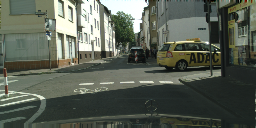

In [118]:
keras.utils.array_to_img(x[0])

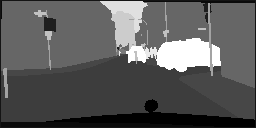

In [119]:
keras.utils.array_to_img(y[0])

In [104]:
import numpy as np

In [120]:
pred = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [121]:
prediction = np.argmax(pred,axis=3,keepdims=True) + np.zeros((32,128,256,3),dtype = np.int8)

In [122]:
prediction.shape

(32, 128, 256, 3)

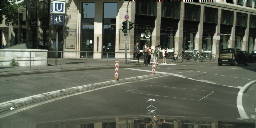

In [126]:
keras.utils.array_to_img(x[31])

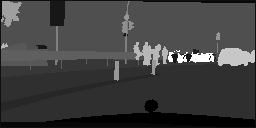

In [127]:
keras.utils.array_to_img(x=y[31])

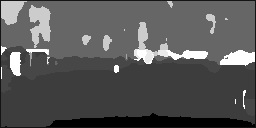

In [128]:
keras.utils.array_to_img(prediction[31])

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
cv2_imshow(y[0])

In [ ]:
cv2_imshow(pred[0])

In [ ]:
y[0]
\

In [ ]:
pred.max()

In [ ]:
layers.